In [1]:
import videoReplayFast
from pykeops.torch import LazyTensor
gen = videoReplayFast.threadedProvide()


In [2]:
q = next(gen) / 255

In [3]:
from torch import nn
import torch
import torch.nn.functional as F
import numpy as np
def pad_or_crop(x, shape, dimension):
    y = x[:, : shape[1]]
    if x.size()[1] < shape[1]:
        if dimension == 3:
            y = F.pad(y, (0, 0, 0, 0, 0, 0, shape[1] - x.size()[1], 0))
        else:
            y = F.pad(y, (0, 0, 0, 0, shape[1] - x.size()[1], 0))
    assert y.size()[1] == shape[1]

    return y
class Residual(nn.Module):
    def __init__(self, features):
        super(Residual, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_features=features)
        self.bn2 = nn.BatchNorm2d(num_features=features)

        self.conv1 = nn.Conv2d(features, features, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, padding=1)

    def forward(self, x):
        y = F.relu(self.bn1(x))
        y = self.conv1(y)
        y = F.relu(self.bn2(y))
        y = self.conv2(y)
        return y + x



class UNet2(nn.Module):
    def __init__(self, num_layers, channels, dimension, input_channels=1):
        super(UNet2, self).__init__()
        self.dimension = dimension
        if dimension == 2:
            self.BatchNorm = nn.BatchNorm2d
            self.Conv = nn.Conv2d
            self.ConvTranspose = nn.ConvTranspose2d
            self.avg_pool = F.avg_pool2d
            self.interpolate_mode = "bilinear"
        else:
            self.BatchNorm = nn.BatchNorm3d
            self.Conv = nn.Conv3d
            self.ConvTranspose = nn.ConvTranspose3d
            self.avg_pool = F.avg_pool3d
            self.interpolate_mode = "trilinear"
        self.num_layers = num_layers
        down_channels = np.array(channels[0])
        up_channels_out = np.array(channels[1])
        up_channels_in = down_channels[1:] + np.concatenate([up_channels_out[1:], [0]])
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])
        self.residues = nn.ModuleList([])
        self.batchNorms = nn.ModuleList(
            [
                self.BatchNorm(num_features=up_channels_out[_])
                for _ in range(self.num_layers)
            ]
        )
        for depth in range(self.num_layers):
            self.downConvs.append(
                self.Conv(
                    down_channels[depth],
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2,
                )
            )
            self.upConvs.append(
                self.ConvTranspose(
                    up_channels_in[depth],
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2,
                )
            )
            self.residues.append(
                Residual(up_channels_out[depth])
            )
        self.lastConv = self.Conv(67, 64, kernel_size=3, padding=1)
        #torch.nn.init.zeros_(self.lastConv.weight)
        #torch.nn.init.zeros_(self.lastConv.bias)

    def forward(self, x):

        skips = []
        for depth in range(self.num_layers):
            skips.append(x)
            y = self.downConvs[depth](F.leaky_relu(x))
            x = y + pad_or_crop(
                self.avg_pool(x, 2, ceil_mode=True), y.size(), self.dimension
            )
            y = F.layer_norm

        for depth in reversed(range(self.num_layers)):
            y = self.upConvs[depth](F.leaky_relu(x))
            #x = y + F.interpolate(
            #    pad_or_crop(x, y.size(), self.dimension),
            #    scale_factor=2,
            #    mode=self.interpolate_mode,
            #    align_corners=False,
            #)
            y = self.residues[depth](y)
            # x = self.batchNorms[depth](x)
            x = y

            x = x[:, :, : skips[depth].size()[2], : skips[depth].size()[3]]
            x = torch.cat([x, skips[depth]], 1)
        x = self.lastConv(x)
        return x
def tallerUNet2(dimension=2):
    return UNet2(
        7,
        [[3, 16, 32, 64, 256, 512, 512, 512], [64, 64, 64, 128, 256, 512, 512]],
        dimension,
    )
def tallerUNet2(dimension=2):
    return UNet2(
        4,
        [[3, 64, 64, 128, 256], [64, 64, 128, 256]],
        dimension,
    )
feature_net = tallerUNet2().cuda()

In [4]:
import torch.nn.functional as F
import random
def warping(net, tensor):
    identity = torch.Tensor([[[1., 0, 0], [0, 1, 0], [0, 0, 1]]]).cuda()
    mask = torch.Tensor([[[1., 1, 1], [1, 1, 1], [0, 0, 0]]]).cuda()
    noise = torch.randn((q.shape[0], 3, 3)).cuda()

    forward = identity + .05 * noise * mask

    backward = torch.inverse(forward)
    
    if random.random() < .5:
        forward, backward = backward, forward

    forward_grid = F.affine_grid(forward[:, :2], q[:, :3].shape)
    
    
    warped_input = F.grid_sample(tensor, forward_grid)
    
    warped_output = net(warped_input)
    
    backward_grid = F.affine_grid(backward[:, :2], warped_output.shape)
    
    unwarped_output = F.grid_sample(warped_output, backward_grid)
    
    return unwarped_output
    
    

In [5]:
b = warping(feature_net, q[:, :3].cuda())
torch.max(b)

/playpen1/tgreer/anaconda3/envs/corr_ext/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/playpen1/tgreer/anaconda3/envs/corr_ext/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(1.8802, device='cuda:0', grad_fn=<MaxBackward1>)

In [6]:
class FMAPModel(nn.Module):

    def __init__(self, net, feature_length=128):
        super().__init__()
        self.feature_length = feature_length

        self.net = net

    def forward(self, input_a, input_b):
        feats_a = self.net(input_a.cuda())[:, :, 60:-40, 60:-40]
        feats_b = self.net(input_b.cuda())[:, :, 60:-40, 60:-40]

        feats_a, feats_b = (
            tn.reshape([feats_a.shape[0], feats_a.shape[1], -1])
             .transpose(1, 2).contiguous() for tn in (feats_a, feats_b)
        )



        M = torch.bmm(feats_a, feats_b.transpose(1, 2))
        #print(M.sum())

        #vs = 1 / (M.sum(1) + .0001)
        #hs = 1 / (M.sum(2) + .0001)

        #(M * vs[:, None]).sum(1) == 1
        #(M * hs[:,:, None]).sum(2) == 1

        res = (torch.softmax(M, axis=1)) * (torch.softmax(M, axis=2))

        loss = torch.log(res.sum(1)).mean()
        loss

        return loss
class FMAPModel2(nn.Module):

    def __init__(self, net, feature_length=128):
        super().__init__()
        self.feature_length = feature_length

        self.net = net

    def forward(self, input_a, input_b):
        feats_a = self.net(input_a.cuda())[:, :, 20:-20, 20:-20]
        feats_b = self.net(input_b.cuda())[:, :, 20:-20, 20:-20]

        feats_a, feats_b = (
            tn.reshape([feats_a.shape[0], feats_a.shape[1], -1])
             .transpose(1, 2).contiguous() for tn in (feats_a, feats_b)
        )

        l_feats_a = LazyTensor(feats_a[:, :, None, :])
        l_feats_b = LazyTensor(feats_b[:, None, :, :])

        M_unn = (l_feats_a * l_feats_b).sum(3)
        
        with torch.no_grad():
            vm = M_unn.max(1)
            hm = M_unn.max(2)
        
        M_v = (M_unn - vm[:, None]).exp()
        
        
        
        M_h = (M_unn - hm[:, :, None]).exp()
        
        

        vs = 1 / (M_v.sum(1) + .0001)
        hs = 1 / (M_h.sum(2) + .0001)

        #(M * vs[:, None]).sum(1) == 1
        #(M * hs[:,:, None]).sum(2) == 1
        
        #l = torch.arange(0, feats_a.shape[1]) * 1.0
        #anti_diag = (LazyTensor(l[None, None, :]) - LazyTensor(l[None, :, None]))

        res = ((M_v * LazyTensor(vs[:, None])) * (M_h * LazyTensor(hs[:, :, None])))
        
        #print(feats_a.shape)
        diag = (feats_a * feats_b).sum(2)
        #print(vs.shape, diag.shape)
        diag_v = (diag - vm[:, :, 0]).exp() * vs[:, :, 0]
        diag_h = (diag - hm[:, :, 0]).exp() * hs[:, :, 0]
        
        
        

        loss = torch.log(res.sum(1) - (diag_v * diag_h)[:, :, None]).mean()
        loss

        return loss
    
class FMAPModelWarping(nn.Module):

    def __init__(self, net, feature_length=128):
        super().__init__()
        self.feature_length = feature_length

        self.net = net

    def forward(self, input_a, input_b):
        feats_a_h = warping(self.net, input_a.cuda())[:, :, 20:-20, 20:-20]
        feats_b_h = warping(self.net, input_b.cuda())[:, :, 20:-20, 20:-20]
        
        feats_a_v = warping(self.net, input_a.cuda())[:, :, 20:-20, 20:-20]
        feats_b_v = warping(self.net, input_b.cuda())[:, :, 20:-20, 20:-20]

        feats_a_h, feats_b_h = (
            tn.reshape([feats_a_h.shape[0], feats_a_h.shape[1], -1])
             .transpose(1, 2).contiguous() for tn in (feats_a_h, feats_b_h)
        )
        
        feats_a_v, feats_b_v = (
            tn.reshape([feats_a_v.shape[0], feats_a_v.shape[1], -1])
             .transpose(1, 2).contiguous() for tn in (feats_a_v, feats_b_v)
        )

        l_feats_a_h = LazyTensor(feats_a_h[:, :, None, :])
        l_feats_b_h = LazyTensor(feats_b_h[:, None, :, :])
        
        l_feats_a_v = LazyTensor(feats_a_v[:, :, None, :])
        l_feats_b_v = LazyTensor(feats_b_v[:, None, :, :])

        M_unn_h = (l_feats_a_h * l_feats_b_h).sum(3)
        M_unn_v = (l_feats_a_v * l_feats_b_v).sum(3)
        
        with torch.no_grad():
            vm = M_unn_v.max(1)
            hm = M_unn_h.max(2)
        
        M_v = (M_unn_v - vm[:, None]).exp()
        
        #print(M_v.max(1))
        
        
        
        M_h = (M_unn_h - hm[:, :, None]).exp()
        
        

        vs = 1 / (M_v.sum(1) + .0001)
        hs = 1 / (M_h.sum(2) + .0001)

        #(M * vs[:, None]).sum(1) == 1
        #(M * hs[:,:, None]).sum(2) == 1
        
        #l = torch.arange(0, feats_a.shape[1]) * 1.0
        #anti_diag = (LazyTensor(l[None, None, :]) - LazyTensor(l[None, :, None]))

        res = ((M_v * LazyTensor(vs[:, None])) * (M_h * LazyTensor(hs[:, :, None])))
        
        #print(feats_a.shape)
        #diag = (feats_a * feats_b).sum(2)
        #print(vs.shape, diag.shape)
        #diag_v = (diag - vm[:, :, 0]).exp() * vs[:, :, 0]
        #diag_h = (diag - hm[:, :, 0]).exp() * hs[:, :, 0]
        
        loss = torch.log(res.sum(1) + .0001).mean()
        loss

        return loss

In [7]:
#loss_model = FMAPModel(feature_net, 64)
loss_model_2 = FMAPModelWarping(feature_net, 64)

In [8]:
#print(loss_model(q[:, :3], q[:, 3:]), loss_model_2(q[:, :3], q[:, 3:]))
#loss_model_2(q[:, :3], q[:, 3:])

In [9]:
import footsteps

Input name of experiment:
warping3


In [ ]:
optimizer = torch.optim.RMSprop(feature_net.parameters(), lr=.00001)
feature_net.train()
feature_net.cuda()
losses = []

for i in range(1000000):
    torch.save(feature_net.state_dict(), footsteps.output_dir + f"network{i:05}.trch")
    torch.save(optimizer.state_dict(), footsteps.output_dir + f"opt{i:05}.trch")
    torch.save(losses, footsteps.output_dir + f"loss{i:05}.trch")
    
    for j in range(1000):
        q = next(gen) / 255
        loss = -loss_model_2(q[:, :3], q[:, 3:])
        loss.backward()
        optimizer.step()
        print(loss)
        losses.append(loss.item())
    


/playpen1/tgreer/anaconda3/envs/corr_ext/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/playpen1/tgreer/anaconda3/envs/corr_ext/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(8.3043, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.2674, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.2521, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.2312, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1974, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1468, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1484, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1345, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0923, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0867, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0656, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0548, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0368, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0780, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0396, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0071, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.9909, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.9785, device='cuda:0', grad_fn=<NegBack

tensor(6.6056, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5996, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5954, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6245, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6194, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6763, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6262, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6289, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6123, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6211, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6540, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6548, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5621, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5412, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5268, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.7139, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.6381, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5956, device='cuda:0', grad_fn=<NegBack

tensor(6.4029, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1947, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2091, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3100, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1664, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1180, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2320, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2926, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3313, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2775, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3080, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1667, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1968, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2076, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1329, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2431, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1605, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.2305, device='cuda:0', grad_fn=<NegBack

tensor(5.7309, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.7825, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6917, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6480, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6307, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.7458, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.8003, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6705, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.5999, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6311, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.5960, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.7117, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6462, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6366, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6199, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.6053, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.4772, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.5916, device='cuda:0', grad_fn=<NegBack

tensor(5.0845, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9902, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0562, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0128, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1495, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.3111, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.2756, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.3400, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1947, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1091, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0734, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0574, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1506, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0858, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1195, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1232, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0870, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0356, device='cuda:0', grad_fn=<NegBack

tensor(4.7601, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7163, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9337, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.8380, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.8556, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7826, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7137, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7895, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7180, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7198, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7744, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.6894, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7157, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7035, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5629, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.6831, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9029, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5613, device='cuda:0', grad_fn=<NegBack

tensor(4.4978, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4100, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5203, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5231, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3788, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7293, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5094, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5733, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.6354, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5830, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5437, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4663, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9396, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5383, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4989, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5658, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5329, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.6326, device='cuda:0', grad_fn=<NegBack

tensor(4.5645, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5368, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5891, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4324, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5818, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5813, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4560, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4526, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4038, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5681, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5304, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5206, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5147, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2931, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5337, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4269, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4179, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4764, device='cuda:0', grad_fn=<NegBack

tensor(4.2961, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4473, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2523, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3825, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4236, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3536, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3714, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4024, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3749, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3544, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4662, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4349, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3824, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4415, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3210, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4347, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3659, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4653, device='cuda:0', grad_fn=<NegBack

tensor(4.2808, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2209, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1231, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2329, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3130, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3036, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2551, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2645, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4526, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2459, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3314, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3151, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3951, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3680, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2252, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2450, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2276, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3231, device='cuda:0', grad_fn=<NegBack

tensor(4.3650, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2037, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3970, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3491, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2044, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3346, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0299, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1692, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1677, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0946, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1417, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3733, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3431, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2570, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2650, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1901, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2572, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2592, device='cuda:0', grad_fn=<NegBack

tensor(4.1840, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0533, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0340, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2745, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1491, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0569, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0779, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0870, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2552, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1278, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3348, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0932, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1134, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1146, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2307, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3246, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1209, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1776, device='cuda:0', grad_fn=<NegBack

tensor(4.0183, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8928, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9502, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0028, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1061, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2580, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1057, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0743, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1999, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2232, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0269, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0237, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1161, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2767, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1033, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1941, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0454, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2063, device='cuda:0', grad_fn=<NegBack

tensor(4.1317, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0929, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8162, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0262, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9547, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8508, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8750, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2199, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0984, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0744, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3301, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8930, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0564, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0576, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1266, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0280, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9957, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9470, device='cuda:0', grad_fn=<NegBack

tensor(4.0360, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8196, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9907, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8795, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0717, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9739, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8112, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0712, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0300, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0775, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9740, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8607, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8567, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7593, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0642, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9942, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0431, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8352, device='cuda:0', grad_fn=<NegBack

tensor(4.0187, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8032, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8855, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8471, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9212, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0318, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8377, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7891, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8028, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8923, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7902, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8407, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7607, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7803, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9428, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1153, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9308, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9322, device='cuda:0', grad_fn=<NegBack

tensor(3.6826, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6945, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7229, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8072, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8896, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0988, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8071, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7955, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7727, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7786, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9274, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7940, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7397, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7002, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8026, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8812, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7650, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7981, device='cuda:0', grad_fn=<NegBack

tensor(3.7951, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7234, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6149, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6151, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7563, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8833, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0030, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8908, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9221, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7640, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8908, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7898, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7801, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9082, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8076, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8584, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7241, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8772, device='cuda:0', grad_fn=<NegBack

tensor(3.6503, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7148, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6913, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6133, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7738, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7016, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5280, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8619, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8223, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8516, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8420, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6583, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8614, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7600, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5951, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7389, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7036, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6987, device='cuda:0', grad_fn=<NegBack

tensor(3.7029, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6615, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5614, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7687, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6739, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9053, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5406, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6840, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7160, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5387, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6394, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5928, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8710, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7172, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5858, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8151, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8044, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6871, device='cuda:0', grad_fn=<NegBack

tensor(3.7838, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6376, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6886, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6614, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6503, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7029, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4869, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9482, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8338, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6799, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7001, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5367, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8460, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7342, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7349, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7669, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7277, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6823, device='cuda:0', grad_fn=<NegBack

tensor(3.6074, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7476, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7556, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5464, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6436, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4516, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6440, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5001, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5208, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4697, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5689, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7357, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4267, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5471, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4909, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7262, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5066, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8178, device='cuda:0', grad_fn=<NegBack

tensor(3.4204, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6447, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5640, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4888, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3426, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5747, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5906, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5842, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5104, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4691, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6066, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4824, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7138, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7393, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5464, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6678, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4191, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4880, device='cuda:0', grad_fn=<NegBack

tensor(3.6285, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6252, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5154, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6936, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6801, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4624, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4252, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4995, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5207, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6425, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5589, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6926, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5230, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5892, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6432, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4160, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5214, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4598, device='cuda:0', grad_fn=<NegBack

tensor(3.2959, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3566, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6261, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6355, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4039, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5138, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5090, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4877, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6453, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6106, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7393, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5863, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5462, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4111, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7286, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5355, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5776, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7362, device='cuda:0', grad_fn=<NegBack

tensor(3.4832, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7633, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5721, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6053, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7282, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7677, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3485, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6428, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7603, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5383, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7456, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5610, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7370, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4847, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6649, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5128, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4050, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6619, device='cuda:0', grad_fn=<NegBack

tensor(3.3537, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5292, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4556, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4806, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3625, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5892, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4626, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5689, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7140, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4513, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5500, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4234, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5040, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3714, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6017, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5143, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5631, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4475, device='cuda:0', grad_fn=<NegBack

tensor(3.5629, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4655, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4671, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4861, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4828, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5107, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5896, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3964, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5631, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5054, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3970, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3656, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5523, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4935, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5635, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3240, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3686, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3906, device='cuda:0', grad_fn=<NegBack

tensor(3.4747, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7087, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4229, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4110, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5657, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3457, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4189, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5701, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3937, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4509, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4619, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3723, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5295, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4765, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4124, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5148, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3660, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4522, device='cuda:0', grad_fn=<NegBack

tensor(3.6014, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5969, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3428, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3155, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5437, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5069, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4778, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2033, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6145, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3640, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3715, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2852, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4585, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4684, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4514, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5730, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5478, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2342, device='cuda:0', grad_fn=<NegBack

tensor(3.5979, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3400, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4641, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5861, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2830, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4693, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7530, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4415, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3612, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5292, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4263, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5080, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3477, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.1632, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4599, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4991, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4267, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3150, device='cuda:0', grad_fn=<NegBack

tensor(3.1322, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2602, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3288, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2825, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4154, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3320, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3207, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3215, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2159, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3259, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3956, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2917, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2580, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3528, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3889, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3434, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3333, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4087, device='cuda:0', grad_fn=<NegBack

tensor(3.5899, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2126, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4751, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4841, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5368, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5369, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2743, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7127, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4811, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3110, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2764, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3757, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5192, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4348, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3049, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2872, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3765, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4071, device='cuda:0', grad_fn=<NegBack

tensor(3.6801, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5316, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5204, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6152, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4836, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4075, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5395, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5497, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4450, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4305, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6187, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.2217, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3810, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5270, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4349, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4810, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5217, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5224, device='cuda:0', grad_fn=<NegBack

tensor(3.4166, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7683, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9161, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3560, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5147, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6811, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5022, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5845, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4761, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5757, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4453, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5711, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7297, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6100, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4967, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6990, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7142, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4952, device='cuda:0', grad_fn=<NegBack

tensor(3.6278, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4970, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4720, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5827, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5822, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0135, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5226, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6692, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5024, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8495, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6581, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4989, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4190, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7076, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9346, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5344, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8179, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6220, device='cuda:0', grad_fn=<NegBack

[matroska,webm @ 0x563101fba440] EBML header parsing failed


tensor(3.6367, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4427, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5984, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4519, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5846, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7024, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7602, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4085, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6224, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4616, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5800, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4536, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5314, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6274, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.3416, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5022, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5995, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6120, device='cuda:0', grad_fn=<NegBack

tensor(3.8321, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9781, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1112, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9288, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5385, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6331, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9932, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8724, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6634, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.5149, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9663, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.8451, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9546, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6812, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7357, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7366, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6369, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.4387, device='cuda:0', grad_fn=<NegBack

tensor(4.9280, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.4349, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1623, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0275, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3144, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.6818, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0632, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.7531, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.2966, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7589, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.5696, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3943, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0486, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.1542, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9205, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3.9534, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.3339, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.0617, device='cuda:0', grad_fn=<NegBack

[matroska,webm @ 0x563102a1fcc0] EBML header parsing failed


tensor(4.8682, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.3320, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.2455, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.5630, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.4233, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1990, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9775, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1108, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0164, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.8442, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9479, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.8819, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.9605, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.0447, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.8102, device='cuda:0', grad_fn=<NegBackward0>)
tensor(4.7787, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.1154, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5.4041, device='cuda:0', grad_fn=<NegBack

tensor(6.7801, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.7239, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3664, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.4885, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.4140, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5654, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.4485, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.4184, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.4590, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.0950, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3675, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5551, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1402, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.1195, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.5303, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3941, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.3460, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.7568, device='cuda:0', grad_fn=<NegBack

tensor(7.0835, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.3088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.3290, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.4966, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.1732, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.1648, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.0476, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.9620, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.2484, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.0944, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.8908, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.4192, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.4325, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.8583, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.1994, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.1233, device='cuda:0', grad_fn=<NegBackward0>)
tensor(6.9354, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.4076, device='cuda:0', grad_fn=<NegBack

tensor(8.0045, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.9595, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.2576, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1664, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1249, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.3086, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.2648, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.2110, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0956, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.9995, device='cuda:0', grad_fn=<NegBackward0>)
tensor(7.9836, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0940, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0995, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.3731, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.3616, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1601, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.1021, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.0873, device='cuda:0', grad_fn=<NegBack

tensor(8.6481, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.6774, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.6742, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7306, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7188, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7396, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7031, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7848, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7550, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7118, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7597, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.6757, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.6964, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7618, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7950, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.7285, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.6634, device='cuda:0', grad_fn=<NegBackward0>)
tensor(8.6877, device='cuda:0', grad_fn=<NegBack

tensor(9.1407, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1177, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1364, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1333, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1261, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1234, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1382, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1262, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1345, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1274, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1275, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1482, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1300, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1322, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1483, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1307, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1554, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.1508, device='cuda:0', grad_fn=<NegBack

tensor(9.2050, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2043, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2052, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2046, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2057, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2052, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2055, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2060, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2049, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2051, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2063, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2060, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2062, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2053, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2060, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2065, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2066, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2066, device='cuda:0', grad_fn=<NegBack

tensor(9.2087, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2087, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2087, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2088, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2087, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2087, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)


[matroska,webm @ 0x563101fba440] EBML header parsing failed


tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBackward0>)
tensor(9.2089, device='cuda:0', grad_fn=<NegBack

In [4]:
feature_net.load_state_dict(torch.load("results/warping3/network00006.trch"))

<All keys matched successfully>

In [5]:
b = feature_net(q[:, :3].cuda())
torch.max(b)

tensor(175.1911, device='cuda:0', grad_fn=<MaxBackward1>)

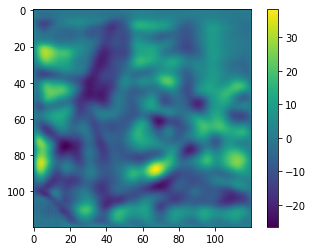

In [6]:
import matplotlib.pyplot as plt
plt.imshow((b[2, 50] - b[3, 50]).cpu().detach())
plt.colorbar()

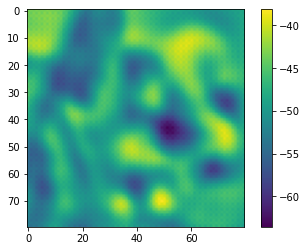

In [13]:
plt.imshow((b[3, 19, 20:-20, 20:-20]).cpu().detach())
plt.colorbar()

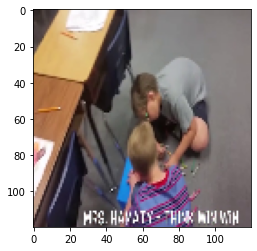

In [8]:
plt.imshow(q[3, [2, 1, 0]].permute([1, 2, 0]))

In [12]:
feats_a = feature_net(q[:, :3].cuda())[:, :, 20:-20, 20:-20]
feats_b = feature_net(q[:, 3:].cuda())[:, :, 20:-20, 20:-20]

feats_a, feats_b = (
    tn.reshape([feats_a.shape[0], feats_a.shape[1], -1])
     .transpose(1, 2).contiguous() for tn in (feats_a, feats_b)
)

l_feats_a = LazyTensor(feats_a[:, :, None, :])
l_feats_b = LazyTensor(feats_b[:, None, :, :])

M_unn = (l_feats_a * l_feats_b).sum(3)

with torch.no_grad():
    vm = M_unn.max(1)
    hm = M_unn.max(2)

M_v = (M_unn - vm[:, None]).exp()



M_h = (M_unn - hm[:, :, None]).exp()



vs = 1 / (M_v.sum(1) + .0001)
hs = 1 / (M_h.sum(2) + .0001)

#(M * vs[:, None]).sum(1) == 1
#(M * hs[:,:, None]).sum(2) == 1

#l = torch.arange(0, feats_a.shape[1]) * 1.0
#anti_diag = (LazyTensor(l[None, None, :]) - LazyTensor(l[None, :, None]))

res = ((M_v * LazyTensor(vs[:, None])) * (M_h * LazyTensor(hs[:, :, None])))

#print(feats_a.shape)
diag = (feats_a * feats_b).sum(2)
#print(vs.shape, diag.shape)
diag_v = (diag - vm[:, :, 0]).exp() * vs[:, :, 0]
diag_h = (diag - hm[:, :, 0]).exp() * hs[:, :, 0]




loss = torch.log(res.sum(1) - (diag_v * diag_h)[:, :, None]).mean()
loss

tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

In [15]:
feats_a

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]